<a href="https://colab.research.google.com/github/hezhonghao/Deep-Learning-Course/blob/main/Scaling_Law_with_CNN_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This is an implementation of scaling law experiments with a simple one conv layer + one fc, with the goals of observing scaling behaviors between test loss and model/dataset size.

I successfully observed the scaling behaviros with both various training dataset sizes and model sizes.

Instruction from Jacob Hilton's advanced DL course:
https://github.com/jacobhilton/deep_learning_curriculum/blob/master/2-Scaling-Laws.md

In [ ]:
# !kill -9 -1 # restart the kernel

This is a coding practice to train a simple MLP for MINST. Aug 7th
Motivation: I've written down numerious code snippets since I took ML/DL courses. But never had I ever executed a complete coding task from the first line to the last line of code.

The code is written in a explicit manner. I hope it particularly helps new learners.

In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.2 MB/s eta 0:00:00


# Set up environment

In [2]:
# libraries
import torch
import torch.nn as nn
import torchvision.datasets as datasets # Import datasets where you may load MNIST
import torch.optim as optim # Where you get optimization function
import torchvision.transforms as transforms # Where you get those data transformation techniques (including normalization, which is necessary)
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import math

from einops import rearrange,reduce

# Loading the data

In [3]:
# Data Normalization
transform = transforms.Compose([
    transforms.ToTensor(), # Transformation happens on GPU
    transforms.Normalize((0.1307,), (0.3081,)), # mean = 0.1307, std = 0.308. This is standard setting for 1 channel grey-scale pictures
])

In [4]:
# Loading the training data

mnist_trainset = datasets.MNIST(root='./sample_data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(mnist_trainset, batch_size=64, shuffle=True, num_workers=4) # For parallel computation



# prep dataset to understand scaling law for training dataset size
subsets = [Subset(mnist_trainset, torch.randperm(len(mnist_trainset))[:int(len(mnist_trainset) * frac)]) for frac in [1, 1/2, 1/4, 1/8, 1/16, 1/32, 1/64, 1/128, 1/256, 1/512]]

sub_train_dataloaders = []
for subset in subsets:
  sub_train_dataloader = DataLoader(subset, batch_size=64, shuffle=True, num_workers=4, drop_last=True)  # when you fragment the dataset as you did above, ess you'd need to drop the last batch because it does not have 64 examples that can be fit into the training scheme.
  sub_train_dataloaders.append(sub_train_dataloader)

# Loading the test data
mnist_testset = datasets.MNIST(root='./sample_data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(mnist_testset, batch_size=64, shuffle=False, num_workers=4)

'''
Learning:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    # Add other necessary transforms here, e.g., normalization
])
This transforms image to tensor. (Notice that transforms.Compose can collect other transformations as well)
Otherwise it would raise the issue that nn.Module can not process "PIL image"
'''


100%|██████████| 9912422/9912422 [00:00<00:00, 257800294.19it/s]

Extracting ./sample_data/MNIST/raw/train-images-idx3-ubyte.gz to ./sample_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 30428458.63it/s]


Extracting ./sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 88558549.91it/s]

Extracting ./sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./sample_data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 6610176.53it/s]


Extracting ./sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw



'\nLearning:\ntransform = transforms.Compose([\n    transforms.ToTensor(),  # Convert PIL image to tensor\n    # Add other necessary transforms here, e.g., normalization\n])\nThis transforms image to tensor. (Notice that transforms.Compose can collect other transformations as well)\nOtherwise it would raise the issue that nn.Module can not process "PIL image"\n'

# Viewing the data (If necessary)



*   It should include things such as transformations, which was included when data was loaded


*   Viewing data is also good to have.



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


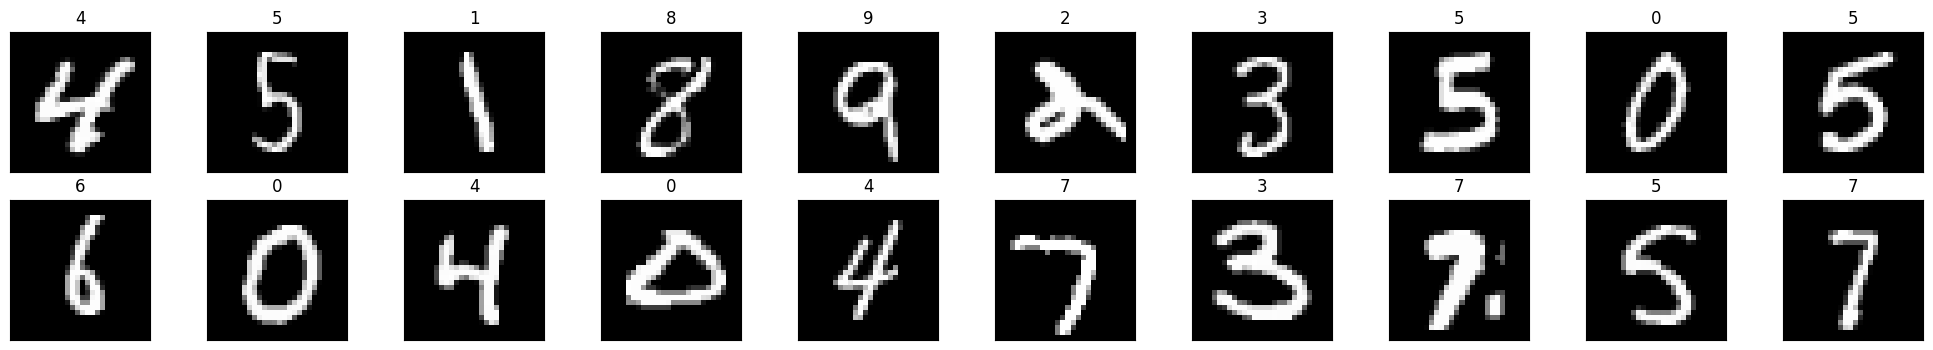

In [5]:
# Viewing data

# Get one batch of data (images and labels)
data_iter = iter(train_dataloader)
images, labels = next(data_iter)

# Plot the images
fig = plt.figure(figsize=(25,4))  # The size of the figure
for idx in range(20): # Show the first 20 images in the batch
  ax = fig.add_subplot(2,10,idx + 1, xticks=[], yticks=[])
  ax.imshow(images[idx].squeeze(), cmap='gray') # squeeze() is used to remove any unnecessary dimensions, e.g., (1, 28, 28) -> (28, 28)
  ax.set_title(str(labels[idx].item()))
plt.show()

# CNN + MLP Layer

Updates:
- Mar 25, 2024 I am adding CNN components into this MLP layer.


Structuree:

*   convolution layer

*   Fully connected layer 1

*   Activation function (specific choice does not matter)

*   FC layer 2

Notice
*   Softmax not included here bc it is implictly included in the Adam optimizer








In [6]:
class Block(nn.Module):
  def __init__(self, in_channels, out_channels, h, w, output_size):
    super(Block, self).__init__()
    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()

    self.fc1 = nn.Linear(out_channels * h * w, out_channels)
    self.G = nn.GELU()
    self.fc2 = nn.Linear(out_channels, output_size)

  def forward(self, x):  # x should be input images of size [batch, color_channels, h, w]
    x = self.conv(x)   # output size: [batch, out_channels, h, w]
    x = self.bn(x)
    x = self.relu(x)

    x = x.view(x.size(0),-1)  # output: [batch, dims=out_channels*h*w]
    x = self.fc1(x)
    x = self.G(x)
    prediction = self.fc2(x)
    return prediction


# Hyper-parameters

Hyper-parameters to be defined:
- lr
- choice of loss function
- choice of optimizer

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Hyperparameters when you adjust training dataset size


In [8]:
# When you want to execute the model
in_channels = 1  # not RGB, just black-n-white
out_channel = 8 # when # filter is fixed and you look to see scaling law relationship between compute and tese loss.
h=w=28  # image size
output_size = 10 # output size for mnist classfication task

# Define the model  # the default model where we may adjust the training dataset size
model = Block(in_channels, out_channel, h, w, output_size)
print('model:', type(model))

# Choice of Loss function
criterion = nn.CrossEntropyLoss()  # The softmax function is contained in this CEL function.

# Choice of optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001) # '.parameters()' is a method of nnModule

model: <class '__main__.Block'>


## Hyperparameters when you adjust model size

In [9]:
# When you want to execute the model
in_channels = 1  # not RGB, just black-n-white
out_channels = [8,11,16,23,32,45,64,91,128,181]
h=w=28  # image size
output_size = 10 # output size for mnist classfication task

# Define the models. You will have a list of models where each has different number of filters (for CNN)
models = []
for out_c in out_channels:
  model = Block(in_channels, out_c, h, w, output_size)
  models.append(model)
print('models:', type(models))


# learning rate
# lr = 0.0001  # I'll start with a default popular lr. But I may adjust per suggestion "The learning rate will need to vary with model size. Either tune it carefully for each model size, or use the rule of thumb that for Adam, the learning rate should be proportional to the initialization scale, i.e. 1/sqrt(fan_in) for the standard Kaiming He initialization (which is what PyTorch generally uses by default)."
#fan_ins = [math.sqrt(out_channel) for out_channel in out_channels]
# lrs = [lr/(fan_in) for fan_in in fan_ins]  # for Adam, the learning rate should be proportional to the initialization scale, i.e. 1/sqrt(fan_in) for the standard Kaiming He initialization

# Assume 'models' is a list of different model instances with varying sizes
optimizers = []


def calculate_fan_in(model):
  # This example assumes the first layer is a Conv2d, adapt it if it's different
  first_layer = list(model.modules())[1]
  fan_in = first_layer.in_channels * first_layer.kernel_size[0] * first_layer.kernel_size[1]
  return fan_in

for model in models:

    # Assume 'fan_in' is predefined or calculated based on the model's first layer
    fan_in = calculate_fan_in(model)
    lr = 0.0001 / math.sqrt(fan_in)  # Adjust learning rate based on model size
    optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizers.append(optimizer)

# Choice of Loss function
criterion = nn.CrossEntropyLoss()  # The softmax function is contained in this CEL function.
# Choice of optimizer
# optimizer = optim.Adam(model.parameters(), lr=lr) # '.parameters()' is a method of nnModule



models: <class 'list'>


# Backpropagation and training loop
You will define a class for backpropation where gradient is calculated

Structure
*   Iterate through every epoch, then every batch
*   Flatten your data: 'b c h w -> (b c)(h w)'
*   Call your model function (forward) to cal predictions (y)
*   Cost & weights 三部曲：cost, zero grad, gradients, weights
*   Graph: If you want to plot cost-epoch graph:
  losses.append(loss.item())  #.item(): from a single-value tensor to a python float


Notice:
*   I didn't use either class or function because we don't need to reuse this.
*   only use "enumerate" when you need to use the index for batch
*   Things per batch: cal cost, zero grad, cal gradients, update weights.




In [14]:
print(type(train_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [15]:
# Debug check
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Using CPU instead.")
    device = torch.device("cpu")

# Later, when defining your model and tensors, you can send them to the chosen device
model = model.to(device)
# And similarly for your tensors
# tensor = tensor.to(device)


CUDA is available. Using GPU: Tesla T4


In [16]:
# Where time spent on GPU
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        # Your model inference here
        data, target = next(iter(train_dataloader))
        prediction = model(data.to(device))

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        14.54%     138.332ms       100.00%     951.359ms     951.359ms       0.000us         0.00%       3.513ms       3.513ms             1  
                                           aten::linear         0.01%     142.000us         5.23%      49.746ms      24.873ms       0.000us         0.00%       2.059ms       1.030ms             2  
         

# Scaling law relevant models training & evaluating
Special:
- One configuration (of training_data size or model size), one model, one test loss (average on epoch)
- Seperately set up model size (how many CNN kernel layers output_layer do you want) and training data (cut training dataset)
- Here we train the model but loss recorded is "test loss", not training loss.


In [17]:
class traineval(nn.Module):
  def __init__(self, criterion):
    super(traineval, self).__init__()
    self.criterion = criterion

  # Weight initialization  # here you don't need to declar "m". It refers to a layer.
  def weights_init(self, m):
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
          torch.nn.init.kaiming_uniform_(m.weight)
          if m.bias is not None:
              torch.nn.init.zeros_(m.bias)

  def train(self, train_data, model, optimizer):  # x is the data input

    # Initialize weights after defining the model architecture
    model.apply(self.weights_init)
    for batch_idx, (data, label) in enumerate(train_data):
      data, label = data.to(device), label.to(device)  # Move data to the same device as the model
      prediction = model(data)
      loss = self.criterion(prediction, label)
      optimizer.zero_grad() # We call zero_grad before each run because you want gradient to be updated for each mini training run (each batch). https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
      loss.backward() # We call ".backward" to calculate gradients for each training run
      optimizer.step() # We update the model weights according to the gradients
      print(f'The {batch_idx} batch, training loss is {loss.item()}')
      # In the end you get a fully trained model.

  def eval(self, train_data, eval_data, model, optimizer):  # x is the data input

    total_loss = 0
    self.train(train_data,model, optimizer) # model is trained in place.
    model.eval() # Set up the model in eval mode (where things such as dropout and normalization will behave differently.)
    with torch.no_grad():
      for batch_idx, (data, label) in enumerate(eval_data): # Notice that eval_data is a dataloader but of tensor dtype
        data, label = data.to(device), label.to(device)  # Move data to the same device as the model
        logits = model(data)  # returning non-normalized probabilities
        # max_values = reduce(logits, "n c ->n", "max") # Notice that this einops method does not work here bc you are looking for the "labels", which are not returned (but only max values)
        loss = self.criterion(logits, label)  # we use criterion to eval performance because it does not only eval accuracy, but also confidence.
        print(f'The {batch_idx} batch, test loss is {loss.item()}')
        total_loss += loss.item()
      total_loss /= len(eval_data) # len(x) is the size of a batch, assuming x is a dataloader (it is)

    model.train() # flip the training on
    return total_loss




## Training models with different dataset sizes
(the smallest being 1/512 of the whole traing set, and the biggest is the whole training set)








In [18]:
losses_1 = []
train_eval_process = traineval(criterion)
for idx, dataloader in enumerate(sub_train_dataloaders):
  loss = train_eval_process.eval(dataloader, test_dataloader, model, optimizer)
  print(f'The {idx} model, test loss is {loss}')
  losses_1.append(loss)





The 0 batch, training loss is 2.830193281173706
The 1 batch, training loss is 2.4406023025512695
The 2 batch, training loss is 2.122882604598999
The 3 batch, training loss is 2.626359701156616
The 4 batch, training loss is 1.7948899269104004
The 5 batch, training loss is 1.7824368476867676
The 6 batch, training loss is 1.1486363410949707
The 7 batch, training loss is 1.090338945388794
The 8 batch, training loss is 1.0275014638900757
The 9 batch, training loss is 0.7056055068969727
The 10 batch, training loss is 0.7750550508499146
The 11 batch, training loss is 0.764167845249176
The 12 batch, training loss is 0.649787187576294
The 13 batch, training loss is 0.5191203355789185
The 14 batch, training loss is 0.9385460615158081
The 15 batch, training loss is 0.6679280400276184
The 16 batch, training loss is 0.4004546105861664
The 17 batch, training loss is 0.5325223207473755
The 18 batch, training loss is 0.6766358017921448
The 19 batch, training loss is 0.45405226945877075
The 20 batch, t

### Normal scale graph - Scaling behavior with dataset size

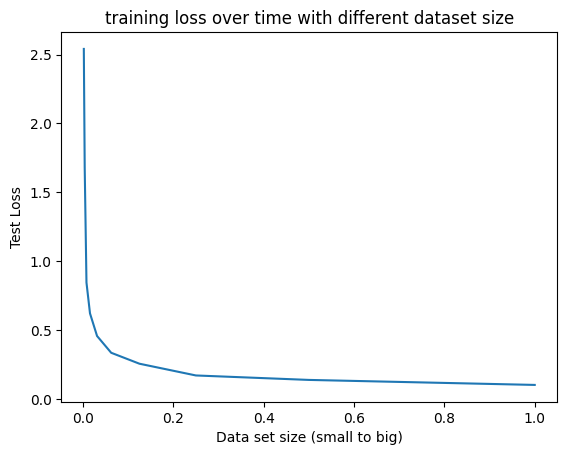

In [24]:
dataset_size = [1, 1/2, 1/4, 1/8, 1/16, 1/32, 1/64, 1/128, 1/256, 1/512] # with "1" as the full dataset
plt.plot(dataset_size, losses_1)
plt.title("training loss over time with different dataset size")
plt.xlabel('Data set size (small to big)')
plt.ylabel('Test Loss')
plt.show()


### Log scale graph - Scaling behavior with dataset size

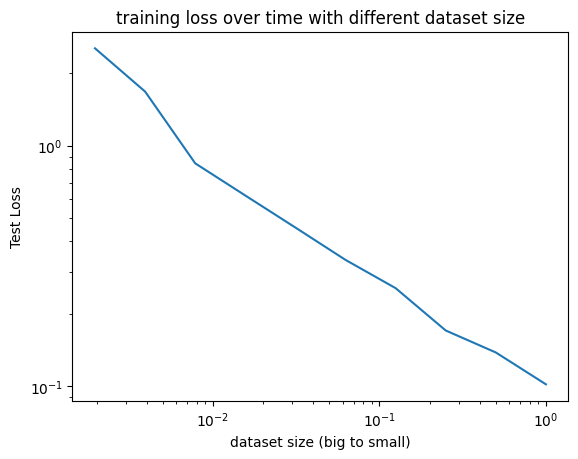

In [25]:
dataset_size = [1, 1/2, 1/4, 1/8, 1/16, 1/32, 1/64, 1/128, 1/256, 1/512] # with "1" as the full dataset
plt.plot(dataset_size, losses_1)
plt.xscale('log') # Adjusts the x-axis to a log scale
plt.yscale('log')
plt.title("training loss over time with different dataset size")
plt.xlabel('dataset size (big to small)')
plt.ylabel('Test Loss')
plt.show()

## Training models with different model sizes
(the smallest has 8 filter/kernals, and the biggest has 181)

In [21]:
losses_2 = []
train_eval_process = traineval(criterion)
for idx, model in enumerate(models):
  model.to(device)  # Move each model to the appropriate device before evaluation
  loss = train_eval_process.eval(sub_train_dataloaders[0], test_dataloader, model, optimizers[idx])  # we train the model with only 0.1 with all the train data. Smaller dataset, less complexity (also it starts with the same configuration of the one with the training dataset size exp)
  print(f'The {idx} model, test loss is {loss}')
  losses_2.append(loss)


Streaming output truncated to the last 5000 lines.
The 475 batch, training loss is 0.2019335776567459
The 476 batch, training loss is 0.166477233171463
The 477 batch, training loss is 0.06532806158065796
The 478 batch, training loss is 0.18439941108226776
The 479 batch, training loss is 0.23681291937828064
The 480 batch, training loss is 0.049047261476516724
The 481 batch, training loss is 0.17299064993858337
The 482 batch, training loss is 0.29772964119911194
The 483 batch, training loss is 0.18083378672599792
The 484 batch, training loss is 0.22331960499286652
The 485 batch, training loss is 0.13397365808486938
The 486 batch, training loss is 0.22347289323806763
The 487 batch, training loss is 0.23647673428058624
The 488 batch, training loss is 0.23532553017139435
The 489 batch, training loss is 0.1785101294517517
The 490 batch, training loss is 0.21883422136306763
The 491 batch, training loss is 0.23768143355846405
The 492 batch, training loss is 0.245193749666214
The 493 batch, tra

### Normal scale graph - Scaling behavior with different model sizes

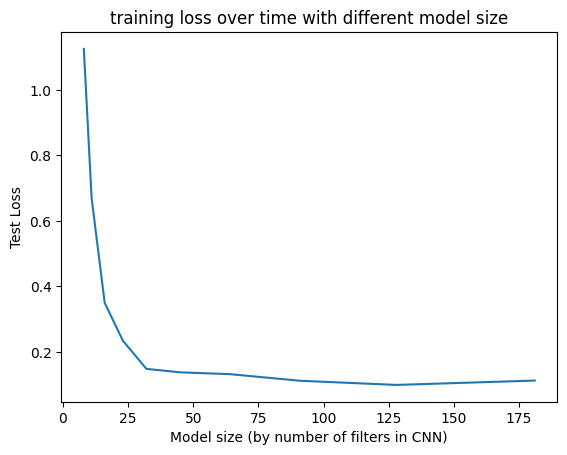

In [22]:
model_size = [8,11,16,23,32,45,64,91,128,181]
plt.plot(model_size, losses_2)
plt.title("training loss over time with different model size")
plt.xlabel('Model size (by number of filters in CNN)')
plt.ylabel('Test Loss')
plt.show()

### Log scale graph

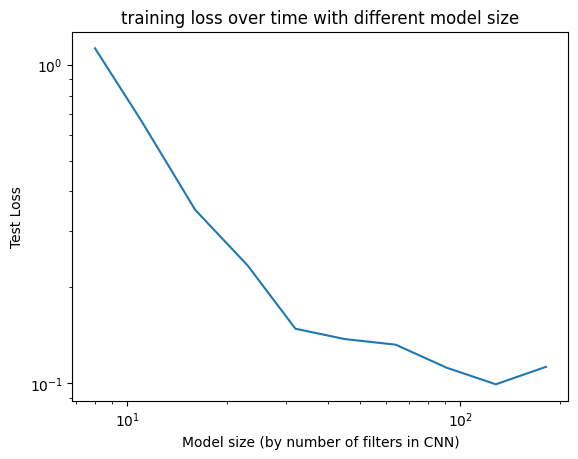

In [23]:
# Log scale, scaling behavior with model size
model_size = [8,11,16,23,32,45,64,91,128,181]
plt.plot(model_size, losses_2)
plt.xscale('log') # Adjusts the x-axis to a log scale
plt.yscale('log')
plt.title("training loss over time with different model size")
plt.xlabel('Model size (by number of filters in CNN)')
plt.ylabel('Test Loss')
plt.show()